In [2]:
from typing_extensions import TypedDict

class State(TypedDict):
    xyz:str
    abc:str

In [5]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel

class OverallState(BaseModel):
    a:str

def node(state:OverallState):
    return {"a":"Hii I am Akhand"}

In [6]:
builder = StateGraph(OverallState)
builder.add_node(node)
builder.add_edge(START,"node")
builder.add_edge("node",END)
graph = builder.compile()

In [7]:
graph.invoke({"a":"Hello"})

{'a': 'Hii I am Akhand'}

In [12]:
try:
    graph.invoke({"a":123})
except:
    print("Enter valid datatype")

Enter valid datatype


In [18]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel

class OverallState(BaseModel):
    a:str

def bad_node(state:OverallState):
    return {
        "a":123
    }

def ok_node(state: OverallState):
    return {
        "a":"goodbyy"
    }

builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START,"bad_node")
builder.add_edge("bad_node","ok_node")
builder.add_edge("ok_node",END)
graph = builder.compile()

In [19]:
graph.invoke({"a":"Akhad"})

ValidationError: 1 validation error for OverallState
a
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type

In [22]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="qwen-2.5-32b")
result = llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003679012, 'queue_time': 0.236575243, 'total_time': 0.053679012}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-d34a3059-5d73-45fd-ba7e-11b39119cba3-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [35]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    topic:str
    joke:str
    improved_joke:str
    final_joke:str

In [42]:
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


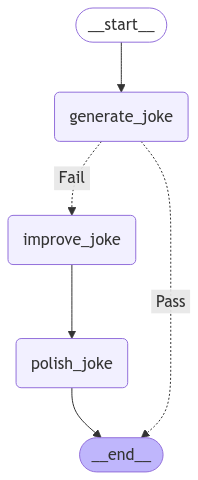

In [43]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [44]:
state = chain.invoke({"topic": "cats"})

In [45]:
state

{'topic': 'cats',
 'joke': "Why don't cats play poker in the wild? Because there are too many cheetahs!",
 'improved_joke': "Why don't cats play poker in the wild? Because there are too many cheetahs, and every game ends with a purr-loot!",
 'final_joke': "Why don't cats play poker in the wild? Because there are too many cheetahs, and every game ends with a purr-loot! But the real twist? The cheetahs aren't actually after the cats' winnings—they're just trying to get close enough to hear the latest gossip in the jungle, as it turns out, cheetahs are the best listeners around!"}

In [48]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# LLM Parallelization

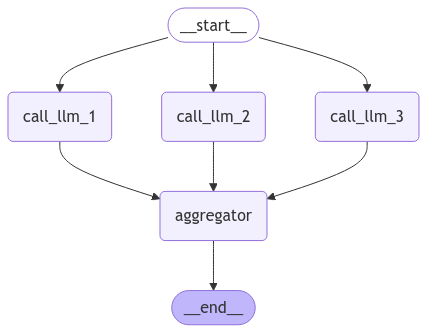

In [57]:
class State(TypedDict):
    topic:str
    joke:str
    story:str
    poem:str
    combined_output:str

# Node creation
def call_llm_1(state:State):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke":msg.content}

def call_llm_2(state:State):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story":msg.content}

def call_llm_3(state:State):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem":msg.content}

def aggregator(state:State):
    """Combine joke, story and poem into a single output"""
    combined = f"Here is the joke, stroy and poem about {state['topic']}! \n\n"
    combined+=f"Story:\n{state['story']}\n\n"
    combined+=f"Joke:\n{state['joke']}\n\n"
    combined+=f"Poem:\n{state['poem']}\n\n"
    return {"combined_output":combined}

# Build workflow
parallel_builder = StateGraph(State)

# Add Node
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add Edges
parallel_builder.add_edge(START,"call_llm_1")
parallel_builder.add_edge(START,"call_llm_2")
parallel_builder.add_edge(START,"call_llm_3")
parallel_builder.add_edge("call_llm_1","aggregator")
parallel_builder.add_edge("call_llm_2","aggregator")
parallel_builder.add_edge("call_llm_3","aggregator")
parallel_builder.add_edge("aggregator", END)

chain = parallel_builder.compile()

display(Image(chain.get_graph().draw_mermaid_png()))


In [58]:
# Invoke
state = chain.invoke({"topic": "cats"})
print(state["combined_output"])

Here is the joke, stroy and poem about cats! 

Story:
In a cozy little town named Whiskerwood, cats ruled the night. The townsfolk whispered tales of a grand gathering of cats beneath the old oak in the center square, where they would share stories of their day’s adventures and plot their mischief for the next day. Among these cats was a sleek black cat with piercing green eyes named Midnight.

Midnight was the youngest of the group but had a spirit that echoed through the corridors of Whiskerwood with a force far beyond her years. She was a curious soul, always seeking new places to explore and new friends to meet. Her best friend was a fluffy white cat named Snowball. Snowball was the opposite of Midnight in many ways—calm, patient, and a great listener. Together, they were the heart of the Whiskerwood gang.

One crisp autumn evening, as the leaves painted the town in shades of gold and orange, Midnight spotted a new cat in the square. He was a ginger tabby with a tuft of fur standin

# LLM Routing

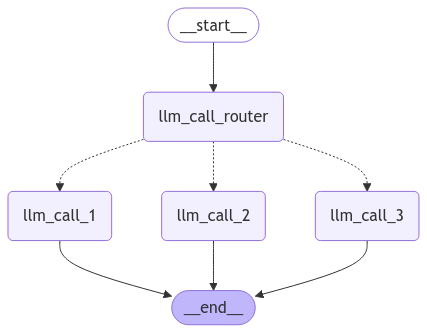

In [64]:
from typing_extensions import Literal
from pydantic import BaseModel,  Field
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal['poem', 'story', 'joke'] = Field(None, description = "The next step in the routing process")

# Augument the LLM with schema for structured output
router = llm.with_structured_output(Route)

# State
class State(TypedDict):
    input: str
    decision: str
    output: str

# Nodes
def llm_call_1(state:State):
    """Write a story"""
    result = llm.invoke(state['input'])
    return {'output':result.content}

def llm_call_2(state:State):
    """Write a joke"""
    result = llm.invoke(state['input'])
    return {'output': result.content}

def llm_call_3(state:State):
    """Write a poem"""
    result = llm.invoke(state['input'])
    return {'output':result.content}

def llm_call_router(state:State):
    """Route the input to the appropriate node"""

    decision = router.invoke(
        [
            SystemMessage(content="Route the input to story, joke or poem based on the user's request"),
            HumanMessage(content=state['input'])
        ]
    )
    return {'decision':decision.step}

def route_decision(state:State):
    if state['decision']=="story":
        return llm_call_1
    if state['decision']=="joke":
        return llm_call_2
    if state['decision']=="poem":
        return llm_call_3
    
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges
router_builder.add_edge(START,"llm_call_router")
router_builder.add_conditional_edges("llm_call_router",route_decisions,
                                     {
                                         "llm_call_1" : "llm_call_1",
                                         "llm_call_2" : "llm_call_2",
                                         "llm_call_3" : "llm_call_3",
                                     },)
router_builder.add_edge("llm_call_1",END)
router_builder.add_edge("llm_call_2",END)
router_builder.add_edge("llm_call_3",END)

router_workflow = router_builder.compile()

display(Image(router_workflow.get_graph().draw_mermaid_png()))


In [65]:
state = router_workflow.invoke({"input" : "Write a joke on GPUs"})
print(state["output"])

KeyError: <function llm_call_2 at 0x782d3a422ca0>